In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from time import time
import timeit
import datetime
from datetime import datetime, timedelta
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import homogeneity_score, adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score as ARI

In [2]:
df_rfm = pd.read_csv('df05.csv')
df = pd.read_csv('df_m0.csv')

In [3]:
data0 = df_rfm.sample(frac=0.15)
data0.shape

(14009, 6)

In [4]:
my_data = data0
X = my_data.drop(['CustomerID','RFM_Score'], axis = 1)

In [5]:
from sklearn import preprocessing
scale = preprocessing.StandardScaler().fit(X)
ada_scaled = scale.transform(X)

In [6]:
df_ada = pd.DataFrame(ada_scaled)
df_ada.columns = ['Recency','Frequency','Monetary','review_score']

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(ada_scaled)

kmeans_model_pca = Pipeline([("preprocessing", StandardScaler()),
                             ("kmeans",KMeans(n_clusters = 4))])
kmeans_model_pca.fit(ada_scaled)

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_

## Modelisation de base

In [8]:
modelKmean = KMeans(n_clusters=4, init="k-means++",random_state=42)
modelKmean.fit(ada_scaled)

KMeans(n_clusters=4, random_state=42)

In [9]:
y_pred= modelKmean.labels_

### Stabilistion du model à l'initialisation

In [10]:
def stab(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [11]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=4, n_init=1, init="k-means++")
    stab(model=imodel, name="Iter "+str(i), data=df_ada, labels=pca_kmeans_labels) 
                 

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
Iter 0   	0.337s	27494	0.999	1.000	0.999
Iter 1   	0.013s	27494	0.987	0.992	0.986
Iter 2   	0.031s	27494	0.989	0.993	0.989
Iter 3   	0.050s	27494	0.988	0.993	0.987
Iter 4   	0.012s	31202	0.401	0.387	0.492
Iter 5   	0.045s	27495	0.990	0.994	0.991
Iter 6   	0.018s	27496	0.993	0.997	0.991
Iter 7   	0.016s	27494	0.989	0.993	0.988
Iter 8   	0.016s	27494	0.997	0.998	0.997
Iter 9   	0.016s	27496	0.983	0.992	0.982
_____________________________________________________


In [12]:
df_rfm

,CustomerID,Recency,Frequency,Monetary,RFM_Score,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,2.38,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,2.37,1
2,0000f46a3911fa3c0805444483337064,541,1,86.22,1.83,1
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,2.02,3
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,2.06,4
...,...,...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,451,2,2067.42,3.94,5
93392,fffea47cd6d3cc0a88bd621562a9d061,266,1,84.58,2.12,3
93393,ffff371b4d645b6ecea244b27531430a,572,1,112.46,1.82,5
93394,ffff5962728ec6157033ef9805bacc48,123,1,133.69,2.36,5


In [13]:
order_timestamp = df.groupby('customer_unique_id')['order_purchase_timestamp'].agg('first').reset_index(name='order_purchase_timestamp')


In [14]:
rfm_merged = pd.merge(order_timestamp, df_rfm, left_on='customer_unique_id', right_on='CustomerID')
rfm_merged = rfm_merged.drop(['order_purchase_timestamp','CustomerID','RFM_Score','review_score'], axis=1)
rfm_merged 

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19
2,0000f46a3911fa3c0805444483337064,541,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.89
...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,451,2,2067.42
93392,fffea47cd6d3cc0a88bd621562a9d061,266,1,84.58
93393,ffff371b4d645b6ecea244b27531430a,572,1,112.46
93394,ffff5962728ec6157033ef9805bacc48,123,1,133.69


In [15]:
rfm_merged['order_purchase_timestamp']= order_timestamp['order_purchase_timestamp']
rfm_merged

,customer_unique_id,Recency,Frequency,Monetary,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,541,1,86.22,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.89,2017-11-14 19:45:42
...,...,...,...,...,...
93391,fffcf5a5ff07b0908bd4e2dbc735a684,451,2,2067.42,2017-06-08 21:00:36
93392,fffea47cd6d3cc0a88bd621562a9d061,266,1,84.58,2017-12-10 20:07:56
93393,ffff371b4d645b6ecea244b27531430a,572,1,112.46,2017-02-07 15:49:16
93394,ffff5962728ec6157033ef9805bacc48,123,1,133.69,2018-05-02 15:17:41


In [16]:
rfm_merged['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [17]:
rfm_merged.dtypes

customer_unique_id                  object
Recency                              int64
Frequency                            int64
Monetary                           float64
order_purchase_timestamp    datetime64[ns]
dtype: object

In [18]:
ARIscore = []
dates = []

# Start and end date of the file
initial_date = "2016-10-09"
final_date = "2018-09-03"

pipe = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters = 4))])

def Simu_fonc(n_iterations, initial_date = initial_date, final_date = final_date, pipe = pipe) :

    for i in range(n_iterations) :

        F0 = rfm_merged[rfm_merged['order_purchase_timestamp'] <= initial_date]
        F0 = F0[F0.columns[1:3]]
        M0 = pipe.fit(F0)

        initial_date = str(datetime.strptime(initial_date, '%Y-%m-%d') + timedelta(days = 15)).split(' ')[0]

        if initial_date <= final_date :

            dates.append(initial_date)

            F1 = rfm_merged[rfm_merged['order_purchase_timestamp'] <= initial_date]
            F1 = F1[F1.columns[1:3]]
            M1_ini = pipe.predict(F1)
            M1_new = pipe.fit(F1)

            ARIscore.append(ARI(M1_ini, M1_new.named_steps['kmeans'].labels_))

        else :

            break

    return pd.DataFrame(ARIscore, dates)

In [19]:
result = Simu_fonc(n_iterations=20)
result

,0
2016-10-24,0.551687
2016-11-08,0.988352
2016-11-23,0.659441
2016-12-08,0.988352
2016-12-23,1.000000
2017-01-07,0.988894
2017-01-22,0.988490
2017-02-06,0.689068
2017-02-21,0.988263
2017-03-08,0.971431


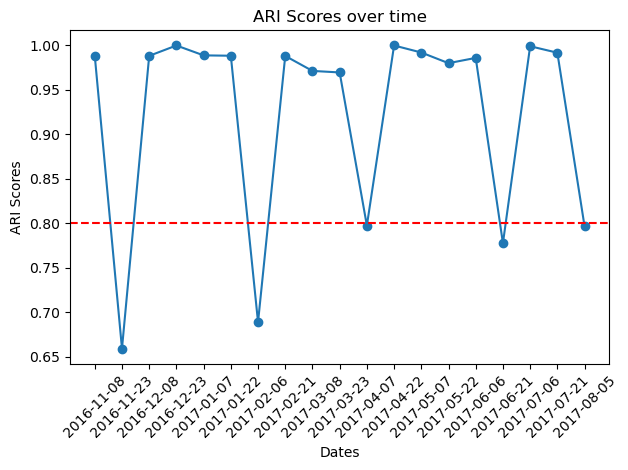

In [20]:
dates = result.index[1:]
ari_scores = result.iloc[1:, 0].values.flatten()

# Graph
plt.plot(dates, ari_scores, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.xlabel('Dates')
plt.ylabel('ARI Scores')
plt.title('ARI Scores over time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()